# Adelie Penguin Colony distances - FUTURE
- Calculate distances from Adelie colonies to CESM grid cells and save as netcdf file.
- Notebook by Alice DuVivier (NCAR)
- October 2024

## Steps for Colonies

1) Load colonies location and initial population file (Adelie_colony_location_future.csv) from Stephanie Jenouvrier (WHOI). The colony names are not in the same order as the present day file and not all colonies match up, so it's necessary to recalculate distances.

2) Calculate for each colony the total distance from Colony to center of each CESM2 grid cells using great circle distance.

3) Save file of distances as netcdf for easier future use

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [2]:
# define great circle distance function - returns in km
# https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97
from math import radians, degrees, sin, cos, asin, acos, sqrt
earth_radius = 6371
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return earth_radius * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

## Read in colony locations

In [3]:
# CSV file 
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'
file_in = 'Adelie_colony_location_future.csv'
fin = path_in + file_in
data = pd.read_csv(fin)

In [4]:
# convert from pandas dataframe to xarray dataset
#type(data)
ds = xr.Dataset.from_dataframe(data)
ds

<xarray.Dataset>
Dimensions:                    (index: 287)
Coordinates:
  * index                      (index) int64 0 1 2 3 4 5 ... 282 283 284 285 286
Data variables:
    site_id                    (index) object 'KUZI' 'BENT' ... 'GRAP' 'FERR'
    site_name                  (index) object 'Kuzira Point' ... 'Ferrier Pen...
    latitude                   (index) float64 -69.6 -69.04 ... -60.72 -60.72
    longitude                  (index) float64 38.27 39.25 ... -44.46 -44.42
    population_median_initial  (index) float64 7.0 9.0 ... 3.7e+04 7.626e+04

## Load CESM2-LE ocean grid

In [5]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [6]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [7]:
# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [8]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [9]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

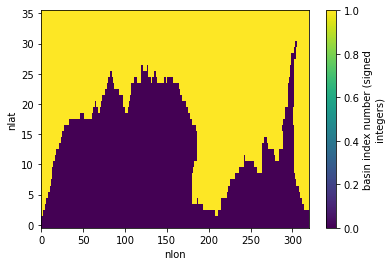

In [10]:
ds_grid.REGION_MASK.plot()

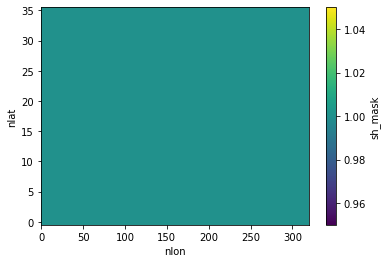

In [11]:
ds_mask.sh_mask.plot()

In [12]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_grid.nlon)
ylen = len(ds_grid.nlat)
clen = len(ds.index)
print(xlen,ylen,clen)

320 36 287


## Calculate distances for **first** colony to test it's working properly

In [13]:
# loop through all grid points to calculate distance from first colony
distances = np.zeros([clen,ylen,xlen])

for col in np.arange(0,clen,1)[0:1]:
    # get lat/lon for this colony
    lon_col = ds.isel(index=col).longitude.values
    lat_col = ds.isel(index=col).latitude.values
    for ind_1 in np.arange(0,ylen,1):
        for ind_2 in np.arange(0,xlen,1):
            lon_grid = ds_grid.TLONG.isel(nlat=ind_1,nlon=ind_2).values
            lat_grid = ds_grid.TLAT.isel(nlat=ind_1,nlon=ind_2).values
            # calculate distance between points
            distances[col,ind_1,ind_2] = great_circle(lon_grid,lat_grid,lon_col,lat_col)

# convert to xarray
distances = xr.DataArray(distances,dims=('colonies','nlat','nlon'))
distances.attrs['units'] = 'km'

# mask distances to omit land points
distances = distances.where(ds_grid.REGION_MASK == 1)

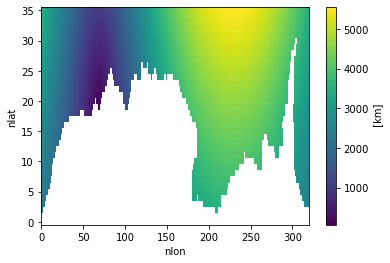

In [14]:
distances.isel(colonies=0).plot()

In [15]:
# find closest distance
distances.isel(colonies=0).min().values

array(58.9734225)

## Calculate distances for each colony

In [16]:
# loop through all grid points to calculate distance from colonies
distances = np.zeros([clen,ylen,xlen])

for ind_1 in np.arange(0,ylen,1):
    for ind_2 in np.arange(0,xlen,1):
        # get lat/lon for this grid point
        lon_grid = ds_grid.TLONG.isel(nlat=ind_1,nlon=ind_2).values
        lat_grid = ds_grid.TLAT.isel(nlat=ind_1,nlon=ind_2).values
        for col in np.arange(0,clen,1):
            # get lat/lon for this colony
            lon_col = ds.isel(index=col).longitude.values
            lat_col = ds.isel(index=col).latitude.values
            # calculate distance between these points
            distances[col,ind_1,ind_2] = great_circle(lon_grid,lat_grid,lon_col,lat_col)

# convert to xarray
distances = xr.DataArray(distances,dims=('colonies','nlat','nlon'))
distances.attrs['units'] = 'km'

# mask distances to omit land points
distances = distances.where(ds_grid.REGION_MASK == 1)

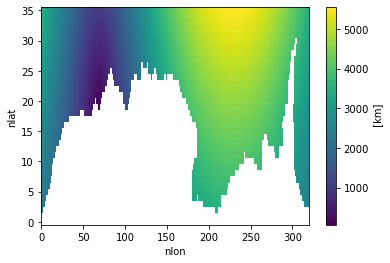

In [17]:
distances.isel(colonies=0).plot()

## Put together into one dataset

- Netcdf with variable dimension: (nlat x nlon)
- Keep the total colonies that can access a cell and the total distances per colony
- Also keep colony information

In [18]:
ds_out = xr.Dataset()

ds_out['colony_distance'] = distances
ds_out['site_id'] = ds.site_id
ds_out['site_name'] = ds.site_name
ds_out['colony_lat'] = ds.latitude
ds_out['colony_lon'] = ds.longitude

ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Adelie Colony distances to CESM2 ocean grid cells for future projections'

ds_out

<xarray.Dataset>
Dimensions:          (nlat: 36, nlon: 320, colonies: 287, index: 287)
Coordinates:
  * nlat             (nlat) int64 0 1 2 3 4 5 6 7 8 ... 28 29 30 31 32 33 34 35
  * nlon             (nlon) int64 0 1 2 3 4 5 6 ... 313 314 315 316 317 318 319
    ULONG            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG            (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT             (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * index            (index) int64 0 1 2 3 4 5 6 ... 280 281 282 283 284 285 286
Dimensions without coordinates: colonies
Data variables:
    colony_distance  (colonies, nlat, nlon) float64 dask.array<chunksize=(287, 36, 320), meta=np.ndarray>
    site_id          (index) object 'KUZI' 'BENT' 'RUMP' ... 'GRAP' 'FERR'
    site_name        (index) object 'Kuzira Point' ... 'Ferrier Peninsula'
    colony_lat       (index) float64 -69.6 -69.04 -69.14 ... -60.72 -60.72
    colony_lon       (index) float64 38.27 39.25 39.39 ... -44.49 -44.46 -44.42
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-09
    contents:        Adelie Colony distances to CESM2 ocean grid cells for fu...

In [19]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	nlat: (36,)
	nlon: (320,)
	colonies: (287,)
	index: (287,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193

## Export and Save

In [20]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.02 GB.


In [21]:
path_out = path_in
file_out = 'CESM_grid_Adelie_colony_future.nc'
fout = path_out + file_out

In [22]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

## Test if it worked

In [24]:
path =  path_out
ds_test =  xr.open_dataset(path_out+file_out, decode_times=True)

In [25]:
ds_test.info()

xarray.Dataset {
dimensions:
	nlat = 36 ;
	nlon = 320 ;
	colonies = 287 ;
	index = 287 ;

variables:
	int64 nlat(nlat) ;
	int64 nlon(nlon) ;
	float64 ULONG(nlat, nlon) ;
		ULONG:long_name = array of u-grid longitudes ;
		ULONG:units = degrees_east ;
	float64 ULAT(nlat, nlon) ;
		ULAT:long_name = array of u-grid latitudes ;
		ULAT:units = degrees_north ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 colony_distance(colonies, nlat, nlon) ;
		colony_distance:units = km ;
	int64 index(index) ;
	object site_id(index) ;
	object site_name(index) ;
	float64 colony_lat(index) ;
	float64 colony_lon(index) ;

// global attributes:
	:author = Alice DuVivier ;
	:date_processed = 2024-10-09 ;
	:contents = Adelie Colony distances to CESM2 ocean grid cells for future projections ;
}

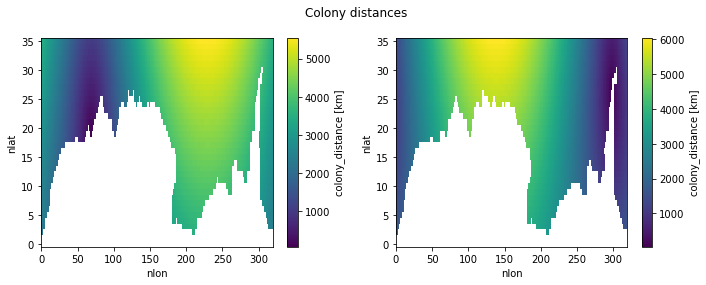

In [26]:
test1 = ds_test.colony_distance.isel(colonies=0)
test2 = ds_test.colony_distance.isel(colonies=200)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

test1.plot(ax=ax1)

test2.plot(ax=ax2)

fig.suptitle("Colony distances")

plt.tight_layout()
plt.show()